# Выбор модели и алгоритма трекинга для обнаружения и отслеживания пешеходов

В данном проекте проводится сравнительный анализ современных моделей детекции семейства **YOLO** и алгоритмов трекинга для задачи обнаружения и отслеживания пешеходов в видео. 

В качестве основного датасета выбран **MOT20** (MOTChallenge 2020), который предоставляет аннотированные видеопоследовательности с высокой плотностью пешеходов в сложных городских условиях.

Используемая GPU - RTX 3070.

In [35]:
import os
import cv2
import supervision as sv
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from ultralytics import YOLO
import torch
from tqdm import tqdm
import time
import pandas as pd
from pathlib import Path
import motmetrics as mm
from boxmot import ByteTrack, BotSort, OcSort, ImprAssocTrack
# Для appearance-based трекеров (StrongSort, DeepOcSort, BoostTrack) раскомментируйте и скачайте ReID-модель
from boxmot import StrongSort, DeepOcSort, BoostTrack
import glob
import configparser
from collections import defaultdict
import optuna

# Загрузка датасета

In [4]:
class MOT20Dataset:
    """
    Класс для загрузки и обработки датасета MOT20
    """
    def __init__(self, root_dir, split='train', verbose=False):
        """
        Инициализация загрузчика MOT20
        
        Args:
            root_dir (str): Путь к корневой папке MOT20
            split (str): Разделение датасета ('train' или 'test')
            verbose (bool): Включить/выключить вывод print
        """
        self.root_dir = root_dir
        self.split = split
        self.sequences = self._get_sequences()
        self.verbose = verbose
        
    def _get_sequences(self):
        """
        Получение списка доступных последовательностей в датасете
        
        Returns:
            list: Список путей к последовательностям
        """
        seq_pattern = os.path.join(self.root_dir, self.split, 'MOT20-*')
        return sorted(glob.glob(seq_pattern))
    
    def get_sequence_info(self, seq_path):
        """
        Загрузка информации о последовательности из файла seqinfo.ini
        
        Args:
            seq_path (str): Путь к папке последовательности
            
        Returns:
            dict: Словарь с информацией о последовательности
        """
        config = configparser.ConfigParser()
        config.read(os.path.join(seq_path, 'seqinfo.ini'))
        
        seq_info = {
            'name': config['Sequence']['name'],
            'frame_rate': int(config['Sequence']['frameRate']),
            'seq_length': int(config['Sequence']['seqLength']),
            'width': int(config['Sequence']['imWidth']),
            'height': int(config['Sequence']['imHeight']),
            'img_extension': config['Sequence']['imExt']
        }
        
        return seq_info
    
    def load_annotations(self, seq_path):
        """
        Загрузка аннотаций из файла gt.txt
        
        Args:
            seq_path (str): Путь к папке последовательности
            
        Returns:
            pandas.DataFrame: Датафрейм с аннотациями
        """
        gt_path = os.path.join(seq_path, 'gt', 'gt.txt')
        
        if not os.path.exists(gt_path):
            if self.verbose:
                print(f"Файл аннотаций не найден: {gt_path}")
            return None
        
        # Формат MOT20: [frame_id, track_id, x, y, width, height, conf, class_id, visibility]
        columns = ['frame_id', 'track_id', 'x', 'y', 'width', 'height', 'conf', 'class_id', 'visibility']
        df = pd.read_csv(gt_path, header=None, names=columns)
        
        return df
    
    def load_detections(self, seq_path):
        """
        Загрузка детекций из файла det.txt
        
        Args:
            seq_path (str): Путь к папке последовательности
            
        Returns:
            pandas.DataFrame: Датафрейм с детекциями
        """
        det_path = os.path.join(seq_path, 'det', 'det.txt')
        
        if not os.path.exists(det_path):
            if self.verbose:
                print(f"Файл детекций не найден: {det_path}")
            return None
        
        # Формат детекций: [frame_id, -1, x, y, width, height, conf, -1, -1, -1]
        columns = ['frame_id', 'placeholder1', 'x', 'y', 'width', 'height', 
                  'conf', 'placeholder2', 'placeholder3', 'placeholder4']
        df = pd.read_csv(det_path, header=None, names=columns)
        
        # Оставляем только нужные столбцы
        df = df[['frame_id', 'x', 'y', 'width', 'height', 'conf']]
        
        return df
    
    def load_frames(self, seq_path, frame_ids=None, max_frames=None):
        """
        Загрузка кадров последовательности
        
        Args:
            seq_path (str): Путь к папке последовательности
            frame_ids (list, optional): Список ID кадров для загрузки
            max_frames (int, optional): Максимальное количество кадров для загрузки
            
        Returns:
            list: Список загруженных кадров
        """
        seq_info = self.get_sequence_info(seq_path)
        img_dir = os.path.join(seq_path, 'img1')
        
        if frame_ids is None:
            # Если frame_ids не указан, загружаем все кадры в порядке возрастания
            frame_ids = list(range(1, seq_info['seq_length'] + 1))
            
            if max_frames is not None:
                frame_ids = frame_ids[:max_frames]
        
        frames = []
        iterator = tqdm(frame_ids, desc="Загрузка кадров") if self.verbose else frame_ids
        for frame_id in iterator:
            # В MOT20 кадры именуются в формате 000001.jpg, 000002.jpg и т.д.
            img_path = os.path.join(img_dir, f'{frame_id:06d}{seq_info["img_extension"]}')
            if os.path.exists(img_path):
                img = cv2.imread(img_path)
                if img is not None:
                    frames.append(img)
                else:
                    if self.verbose:
                        print(f"Не удалось загрузить кадр: {img_path}")
            else:
                if self.verbose:
                    print(f"Кадр не найден: {img_path}")
        
        return frames
    
    def visualize_frame_with_annotations(self, frame, annotations, show_track_id=True):
        """
        Визуализация кадра с аннотациями
        
        Args:
            frame (np.ndarray): Кадр для визуализации
            annotations (pandas.DataFrame): Аннотации для данного кадра
            show_track_id (bool): Отображать ли ID трека
            
        Returns:
            np.ndarray: Кадр с отрисованными аннотациями
        """
        vis_frame = frame.copy()
        
        # Генерируем цвета для разных треков
        np.random.seed(42)  # для воспроизводимости
        color_map = {}
        
        for _, ann in annotations.iterrows():
            track_id = int(ann['track_id'])
            
            if track_id not in color_map:
                color_map[track_id] = tuple(map(int, np.random.randint(0, 255, 3)))
            
            color = color_map[track_id]
            
            x, y, w, h = int(ann['x']), int(ann['y']), int(ann['width']), int(ann['height'])
            
            # Рисуем прямоугольник
            cv2.rectangle(vis_frame, (x, y), (x+w, y+h), color, 2)
            
            if show_track_id:
                # Отображаем ID трека
                cv2.putText(vis_frame, f"ID: {track_id}", (x, y-10), 
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        return vis_frame
    
    def create_video_with_annotations(self, seq_path, output_path, max_frames=None):
        """
        Создание видео с отображением аннотаций
        
        Args:
            seq_path (str): Путь к папке последовательности
            output_path (str): Путь для сохранения выходного видео
            max_frames (int, optional): Максимальное количество кадров
        """
        seq_info = self.get_sequence_info(seq_path)
        annotations = self.load_annotations(seq_path)
        
        if annotations is None:
            if self.verbose:
                print(f"Нет доступных аннотаций для {seq_path}")
            return
        
        # Создаем словарь аннотаций по кадрам
        frame_to_annotations = defaultdict(list)
        for _, ann in annotations.iterrows():
            frame_to_annotations[int(ann['frame_id'])].append(ann)
        
        # Загружаем все кадры или ограниченное количество
        frames = self.load_frames(seq_path, max_frames=max_frames)
        
        if not frames:
            if self.verbose:
                print("Не удалось загрузить кадры.")
            return
        
        # Устанавливаем кодек и создаем объект VideoWriter
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        height, width = frames[0].shape[:2]
        video_writer = cv2.VideoWriter(output_path, fourcc, seq_info['frame_rate'], (width, height))
        
        # Создаем видео с аннотациями
        iterator = tqdm(frames, desc="Создание видео") if self.verbose else enumerate(frames)
        for frame_idx, frame in (iterator if self.verbose else enumerate(frames)):
            # Индексы кадров в MOT20 начинаются с 1
            frame_id = frame_idx + 1
            
            # Получаем аннотации для текущего кадра
            if frame_id in frame_to_annotations:
                frame_annotations = pd.DataFrame(frame_to_annotations[frame_id])
                vis_frame = self.visualize_frame_with_annotations(frame, frame_annotations)
            else:
                vis_frame = frame
            
            # Записываем кадр в видео
            video_writer.write(vis_frame)
        
        video_writer.release()
        if self.verbose:
            print(f"Видео сохранено: {output_path}")

## Инициализация датасета и просмотр последовательностей

In [5]:
dataset = MOT20Dataset(root_dir="MOT20", split="train")
print('Доступные последовательности:', [os.path.basename(seq) for seq in dataset.sequences])

Доступные последовательности: ['MOT20-01', 'MOT20-02', 'MOT20-03', 'MOT20-05']


## Информация о первой последовательности и аннотации

In [6]:
sample_seq = dataset.sequences[0]
seq_info = dataset.get_sequence_info(sample_seq)
print('Информация о последовательности:')
for k, v in seq_info.items():
    print(f'{k}: {v}')
annotations = dataset.load_annotations(sample_seq)
annotations = annotations[annotations['class_id'] == 1]
print('Пример аннотаций:')
display(annotations.head())

Информация о последовательности:
name: MOT20-01
frame_rate: 25
seq_length: 429
width: 1920
height: 1080
img_extension: .jpg
Пример аннотаций:


,frame_id,track_id,x,y,width,height,conf,class_id,visibility
0,1,1,199,813,140,268,1,1,0.83643
1,2,1,201,812,140,268,1,1,0.84015
2,3,1,203,812,140,268,1,1,0.84015
3,4,1,206,812,140,268,1,1,0.84015
4,5,1,208,812,140,268,1,1,0.84015


In [7]:
# Вывод уникальных class_id и их количества
if 'class_id' in annotations.columns:
    unique_classes = annotations['class_id'].unique()
    print(f'Уникальные class_id: {unique_classes}')
    print(f'Количество уникальных class_id: {len(unique_classes)}')

Уникальные class_id: [1]
Количество уникальных class_id: 1


## Визуализация первого кадра с аннотациями

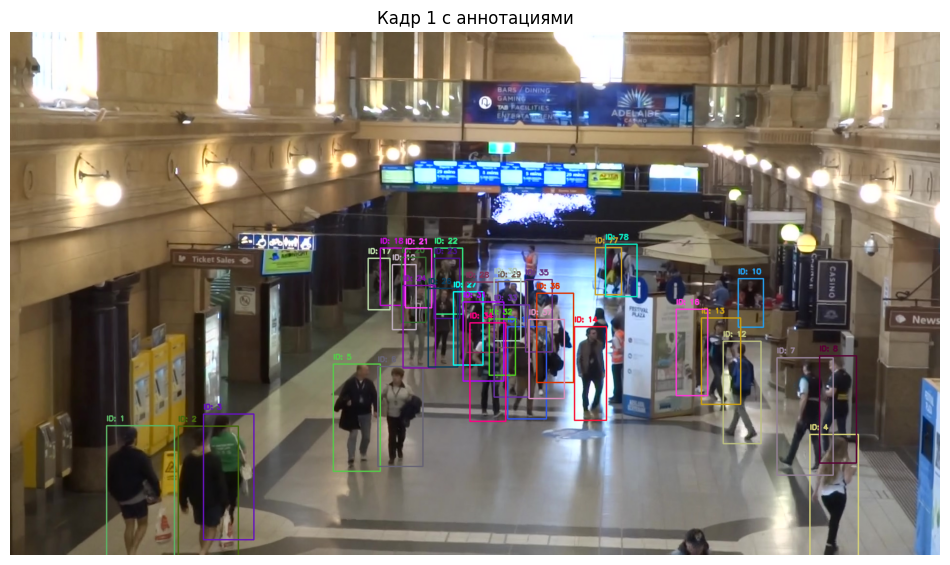

In [8]:
frames = dataset.load_frames(sample_seq, max_frames=1)
frame1 = frames[0]
frame1_anns = annotations[annotations['frame_id'] == 1]
vis_frame = dataset.visualize_frame_with_annotations(frame1, frame1_anns)
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(vis_frame, cv2.COLOR_BGR2RGB))
plt.title('Кадр 1 с аннотациями')
plt.axis('off')
plt.show()

# Сравнение моделей

In [9]:
# Функция для подсчета Intersection over Union
def compute_iou(boxA, boxB):
    # box = [x, y, w, h]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

In [10]:
# функция для подсчета mAP
def average_precision(recalls, precisions):
    recalls = np.concatenate(([0.], recalls, [1.]))
    precisions = np.concatenate(([0.], precisions, [0.]))
    for i in range(len(precisions) - 1, 0, -1):
        precisions[i - 1] = np.maximum(precisions[i - 1], precisions[i])
    indices = np.where(recalls[1:] != recalls[:-1])[0]
    ap = np.sum((recalls[indices + 1] - recalls[indices]) * precisions[indices + 1])
    return ap


In [11]:
def evaluate_model_on_mot20(model_path, dataset, num_frames=10, iou_threshold=0.5, device='cpu'):
    model = YOLO(model_path)
    model.to(device)
    all_precisions = []
    all_recalls = []
    all_aps = []
    total_time = 0
    total_frames = 0
    for sample_seq in dataset.sequences[:2]:
        frames = dataset.load_frames(sample_seq, max_frames=num_frames)
        gt = dataset.load_annotations(sample_seq)
        gt = gt[gt['class_id'] == 1]  # Только люди
        for idx, frame in enumerate(tqdm(frames, desc=f"{model_path} | {os.path.basename(sample_seq)}")):
            frame_id = idx + 1
            gt_boxes = gt[gt['frame_id'] == frame_id][['x', 'y', 'width', 'height']].values
            start = time.time()
            results = model(frame, device=device, verbose=False)[0]
            total_time += time.time() - start
            pred_boxes = []
            pred_scores = []
            for box, score, cls in zip(results.boxes.xywh.cpu().numpy(), results.boxes.conf.cpu().numpy(), results.boxes.cls.cpu().numpy()):
                if int(cls) == 0:  # класс 0 - человек для COCO
                    x, y, w, h = box
                    pred_boxes.append([x - w/2, y - h/2, w, h])
                    pred_scores.append(score)
            pred_boxes = np.array(pred_boxes)
            pred_scores = np.array(pred_scores)
            # Сортировка по score
            if len(pred_scores) > 0:
                order = np.argsort(-pred_scores)
                pred_boxes = pred_boxes[order]
                pred_scores = pred_scores[order]
            matched = set()
            tp = np.zeros(len(pred_boxes))
            fp = np.zeros(len(pred_boxes))
            for i, pb in enumerate(pred_boxes):
                found = False
                for j, gb in enumerate(gt_boxes):
                    if j in matched:
                        continue
                    iou = compute_iou(pb, gb)
                    if iou >= iou_threshold:
                        tp[i] = 1
                        matched.add(j)
                        found = True
                        break
                if not found:
                    fp[i] = 1
            cum_tp = np.cumsum(tp)
            cum_fp = np.cumsum(fp)
            recalls = cum_tp / (len(gt_boxes) + 1e-6)
            precisions = cum_tp / (cum_tp + cum_fp + 1e-6)
            ap = average_precision(recalls, precisions)
            all_aps.append(ap)
            if len(precisions) > 0:
                all_precisions.append(precisions[-1])
                all_recalls.append(recalls[-1])
            else:
                all_precisions.append(0)
                all_recalls.append(0)
            total_frames += 1
    mean_precision = np.mean(all_precisions)
    mean_recall = np.mean(all_recalls)
    mean_ap = np.mean(all_aps)
    fps = total_frames / total_time if total_time > 0 else 0
    return mean_precision, mean_recall, mean_ap, fps


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Используемое устройство: {device}")
dataset = MOT20Dataset(root_dir="MOT20", split="train")
yolo_models = [
    'yolov8x.pt',
    'yolov8l.pt',
    'yolov8n.pt',
    'yolov9t.pt',
    'yolov10n.pt',
    'yolo11n.pt',
    'yolo12n.pt',
    'yolov8s.pt',
    'yolov9s.pt',
    'yolov10s.pt',
    'yolo11s.pt',
    'yolo12s.pt',
    'yolov8m.pt',
    'yolov9m.pt',
    'yolov10m.pt',
    'yolo11m.pt',
    'yolo12m.pt',
]

results = {}
for model_path in yolo_models:
    #if not os.path.exists('models/' + model_path):
    #    print(f"Модель {model_path} не найдена, пропуск...")
    #    continue
    print(f"Тест модели: {model_path}")
    mean_prec, mean_rec, mean_ap, fps = evaluate_model_on_mot20('models/' + model_path, dataset, num_frames=-1, device=device)
    print(f"Precision@IoU=0.5: {mean_prec:.3f}, Recall: {mean_rec:.3f}, mAP: {mean_ap:.3f}, FPS: {fps:.2f}")
    results[model_path] = (mean_prec, mean_rec, mean_ap, fps)
df = pd.DataFrame([
        {
            'Model': model_path,
            'Precision@IoU=0.5': f"{prec:.3f}",
            'Recall': f"{rec:.3f}",
            'mAP': f"{ap:.3f}",
            'FPS': f"{fps:.2f}"
        }
        for model_path, (prec, rec, ap, fps) in results.items()
    ])
df

Используемое устройство: cuda
Тест модели: yolov8x.pt


models/yolov8x.pt | MOT20-01: 100%|██████████| 428/428 [00:20<00:00, 20.48it/s]
models/yolov8x.pt | MOT20-02: 100%|██████████| 2781/2781 [03:37<00:00, 12.77it/s]


Precision@IoU=0.5: 0.928, Recall: 0.396, mAP: 0.386, FPS: 13.99
Тест модели: yolov8l.pt


100%|██████████| 83.7M/83.7M [00:07<00:00, 11.1MB/s]
models/yolov8l.pt | MOT20-01: 100%|██████████| 428/428 [00:19<00:00, 21.52it/s]
models/yolov8l.pt | MOT20-02: 100%|██████████| 2781/2781 [02:03<00:00, 22.52it/s]


Precision@IoU=0.5: 0.941, Recall: 0.365, mAP: 0.358, FPS: 23.79
Тест модели: yolov8n.pt


models/yolov8n.pt | MOT20-01: 100%|██████████| 428/428 [00:05<00:00, 76.33it/s]
models/yolov8n.pt | MOT20-02: 100%|██████████| 2781/2781 [00:33<00:00, 83.58it/s]


Precision@IoU=0.5: 0.911, Recall: 0.363, mAP: 0.354, FPS: 101.37
Тест модели: yolov9t.pt


models/yolov9t.pt | MOT20-01: 100%|██████████| 428/428 [00:08<00:00, 49.79it/s]
models/yolov9t.pt | MOT20-02: 100%|██████████| 2781/2781 [00:54<00:00, 51.20it/s]


Precision@IoU=0.5: 0.927, Recall: 0.335, mAP: 0.328, FPS: 57.52
Тест модели: yolov10n.pt


models/yolov10n.pt | MOT20-01: 100%|██████████| 428/428 [00:05<00:00, 78.34it/s]
models/yolov10n.pt | MOT20-02: 100%|██████████| 2781/2781 [00:30<00:00, 91.26it/s]


Precision@IoU=0.5: 0.954, Recall: 0.189, mAP: 0.187, FPS: 105.65
Тест модели: yolo11n.pt


models/yolo11n.pt | MOT20-01: 100%|██████████| 428/428 [00:05<00:00, 76.12it/s]
models/yolo11n.pt | MOT20-02: 100%|██████████| 2781/2781 [00:34<00:00, 79.80it/s]


Precision@IoU=0.5: 0.937, Recall: 0.319, mAP: 0.313, FPS: 94.48
Тест модели: yolo12n.pt


models/yolo12n.pt | MOT20-01: 100%|██████████| 428/428 [00:06<00:00, 61.47it/s]
models/yolo12n.pt | MOT20-02: 100%|██████████| 2781/2781 [00:44<00:00, 63.19it/s]


Precision@IoU=0.5: 0.950, Recall: 0.288, mAP: 0.283, FPS: 72.45
Тест модели: yolov8s.pt


models/yolov8s.pt | MOT20-01: 100%|██████████| 428/428 [00:05<00:00, 72.61it/s]
models/yolov8s.pt | MOT20-02: 100%|██████████| 2781/2781 [00:32<00:00, 85.17it/s]


Precision@IoU=0.5: 0.925, Recall: 0.379, mAP: 0.370, FPS: 100.78
Тест модели: yolov9s.pt


models/yolov9s.pt | MOT20-01: 100%|██████████| 428/428 [00:08<00:00, 48.42it/s]
models/yolov9s.pt | MOT20-02: 100%|██████████| 2781/2781 [00:55<00:00, 49.78it/s]


Precision@IoU=0.5: 0.935, Recall: 0.366, mAP: 0.358, FPS: 55.73
Тест модели: yolov10s.pt


models/yolov10s.pt | MOT20-01: 100%|██████████| 428/428 [00:05<00:00, 79.90it/s]
models/yolov10s.pt | MOT20-02: 100%|██████████| 2781/2781 [00:32<00:00, 86.03it/s]


Precision@IoU=0.5: 0.954, Recall: 0.221, mAP: 0.218, FPS: 99.79
Тест модели: yolo11s.pt


models/yolo11s.pt | MOT20-01: 100%|██████████| 428/428 [00:05<00:00, 74.04it/s]
models/yolo11s.pt | MOT20-02: 100%|██████████| 2781/2781 [00:36<00:00, 76.70it/s]


Precision@IoU=0.5: 0.938, Recall: 0.342, mAP: 0.334, FPS: 90.70
Тест модели: yolo12s.pt


models/yolo12s.pt | MOT20-01: 100%|██████████| 428/428 [00:06<00:00, 63.36it/s]
models/yolo12s.pt | MOT20-02: 100%|██████████| 2781/2781 [00:42<00:00, 65.32it/s]


Precision@IoU=0.5: 0.963, Recall: 0.237, mAP: 0.234, FPS: 73.74
Тест модели: yolov8m.pt


models/yolov8m.pt | MOT20-01: 100%|██████████| 428/428 [00:09<00:00, 45.81it/s]
models/yolov8m.pt | MOT20-02: 100%|██████████| 2781/2781 [01:00<00:00, 45.94it/s]


Precision@IoU=0.5: 0.933, Recall: 0.397, mAP: 0.388, FPS: 51.36
Тест модели: yolov9m.pt


models/yolov9m.pt | MOT20-01: 100%|██████████| 428/428 [00:11<00:00, 36.40it/s]
models/yolov9m.pt | MOT20-02: 100%|██████████| 2781/2781 [01:16<00:00, 36.55it/s]


Precision@IoU=0.5: 0.935, Recall: 0.391, mAP: 0.382, FPS: 40.10
Тест модели: yolov10m.pt


models/yolov10m.pt | MOT20-01: 100%|██████████| 428/428 [00:08<00:00, 48.91it/s]
models/yolov10m.pt | MOT20-02: 100%|██████████| 2781/2781 [00:54<00:00, 50.64it/s]


Precision@IoU=0.5: 0.946, Recall: 0.277, mAP: 0.272, FPS: 56.34
Тест модели: yolo11m.pt


models/yolo11m.pt | MOT20-01: 100%|██████████| 428/428 [00:09<00:00, 44.11it/s]
models/yolo11m.pt | MOT20-02: 100%|██████████| 2781/2781 [01:01<00:00, 45.02it/s]


Precision@IoU=0.5: 0.947, Recall: 0.321, mAP: 0.313, FPS: 49.57
Тест модели: yolo12m.pt


models/yolo12m.pt | MOT20-01: 100%|██████████| 428/428 [00:10<00:00, 38.94it/s]
models/yolo12m.pt | MOT20-02: 100%|██████████| 2781/2781 [01:10<00:00, 39.60it/s]


Precision@IoU=0.5: 0.958, Recall: 0.260, mAP: 0.256, FPS: 42.98


,Model,Precision@IoU=0.5,Recall,mAP,FPS
0,yolov8x.pt,0.928,0.396,0.386,13.99
1,yolov8l.pt,0.941,0.365,0.358,23.79
2,yolov8n.pt,0.911,0.363,0.354,101.37
3,yolov9t.pt,0.927,0.335,0.328,57.52
4,yolov10n.pt,0.954,0.189,0.187,105.65
5,yolo11n.pt,0.937,0.319,0.313,94.48
6,yolo12n.pt,0.950,0.288,0.283,72.45
7,yolov8s.pt,0.925,0.379,0.370,100.78
8,yolov9s.pt,0.935,0.366,0.358,55.73
9,yolov10s.pt,0.954,0.221,0.218,99.79


In [13]:
df.sort_values(by=['mAP'], ascending=False)

,Model,Precision@IoU=0.5,Recall,mAP,FPS
12,yolov8m.pt,0.933,0.397,0.388,51.36
0,yolov8x.pt,0.928,0.396,0.386,13.99
13,yolov9m.pt,0.935,0.391,0.382,40.10
7,yolov8s.pt,0.925,0.379,0.370,100.78
1,yolov8l.pt,0.941,0.365,0.358,23.79
8,yolov9s.pt,0.935,0.366,0.358,55.73
2,yolov8n.pt,0.911,0.363,0.354,101.37
10,yolo11s.pt,0.938,0.342,0.334,90.70
3,yolov9t.pt,0.927,0.335,0.328,57.52
5,yolo11n.pt,0.937,0.319,0.313,94.48


Из представленных данных YOLOv8m демонстрирует оптимальный баланс между точностью и скоростью.

Камеры видеонаблюдения записывают в 25-30 FPS, поэтому данная модель сможет производить детекцию в реальном времени при использовании GPU уровня RTX 3070 и выше.

# Тестирование алгоритмов трекинга

Для реализации использован фреймворк boxmot, который позволяет использовать различные SOTA-трекеры

В качестве ReID-модели используется osnet_x0_25_msmt17, обеспечивающая достаточную скорость для live-обработки

In [15]:
# Конфиг
YOLO_MODEL = 'models/yolov8m.pt'
MOT20_PATH = './MOT20'
RESULTS_CSV = 'boxmot_custom_tracking_results.csv'
DEVICE = 0 if torch.cuda.is_available() else 'cpu'
REID_MODEL = Path("models/osnet_x0_25_msmt17.pt")
NUM_FRAMES = -1 

TRACKERS = {
    'bytetrack': lambda: ByteTrack(),
    'botsort': lambda: BotSort(reid_weights=REID_MODEL, device=DEVICE, half=True),
    'ocsort': lambda: OcSort(),
    'imprassoc': lambda: ImprAssocTrack(reid_weights=REID_MODEL, device=DEVICE, half=True),
    'strongsort': lambda: StrongSort(reid_weights=REID_MODEL, device=DEVICE, half=True),
    'deepocsort': lambda: DeepOcSort(reid_weights=REID_MODEL, device=DEVICE, half=True),
    'boosttrack': lambda: BoostTrack(reid_weights=REID_MODEL, device=DEVICE, half=True),
}

In [16]:
def get_yolo_detector():
    model = YOLO(YOLO_MODEL)
    model.to(DEVICE)
    return model

def get_detections_yolo(model, frame):
    results = model(frame, device=DEVICE, verbose=False)[0]
    dets = []
    for box, score, cls in zip(results.boxes.xyxy.cpu().numpy(), results.boxes.conf.cpu().numpy(), results.boxes.cls.cpu().numpy()):
        if int(cls) == 0:  # только человек
            dets.append(np.concatenate([box, [score, 0]]))  # 0 — класс человек
    return np.array(dets)  # [x1, y1, x2, y2, score]

def bbox_iou_matrix(gt_boxes, pred_boxes):
    if len(gt_boxes) == 0 or len(pred_boxes) == 0:
        return np.ones((len(gt_boxes), len(pred_boxes)))
    ious = np.zeros((len(gt_boxes), len(pred_boxes)))
    for i, g in enumerate(gt_boxes):
        for j, p in enumerate(pred_boxes):
            gx1, gy1, gw, gh = g
            gx2, gy2 = gx1 + gw, gy1 + gh
            px1, py1, px2, py2 = p
            ix1, iy1 = max(gx1, px1), max(gy1, py1)
            ix2, iy2 = min(gx2, px2), min(gy2, py2)
            iw, ih = max(0, ix2 - ix1), max(0, iy2 - iy1)
            inter = iw * ih
            ga = gw * gh
            pa = (px2 - px1) * (py2 - py1)
            union = ga + pa - inter + 1e-6
            iou = inter / union if union > 0 else 0
            ious[i, j] = 1 - iou
    return ious

In [17]:
# Загрузка датасета и выбор видео
dataset = MOT20Dataset(root_dir=MOT20_PATH, split='train', verbose=False)
print('Доступные видео:', [os.path.basename(seq) for seq in dataset.sequences])
video_idx = 1  # можно изменить индекс
seq_path = dataset.sequences[video_idx]
seq_name = os.path.basename(seq_path)
print('Выбрано видео:', seq_name)

Доступные видео: ['MOT20-01', 'MOT20-02', 'MOT20-03', 'MOT20-05']
Выбрано видео: MOT20-02


In [18]:
# Загрузка GT и кадров
gt = dataset.load_annotations(seq_path)
gt = gt[gt['class_id'] == 1]
frames = dataset.load_frames(seq_path, max_frames=NUM_FRAMES)
print(f'Загружено кадров: {len(frames)}')

Загружено кадров: 2781


In [19]:
# Получаем YOLO-детекции для всех кадров (только один раз)
yolo = get_yolo_detector()
all_detections = []
for frame in tqdm(frames, desc="YOLO detections"):
    dets = get_detections_yolo(yolo, frame)
    all_detections.append(dets)

YOLO detections: 100%|██████████| 2781/2781 [00:53<00:00, 51.98it/s]


In [20]:
# Тестирование трекеров
yolo = get_yolo_detector()
metrics = ['mota', 'motp', 'idf1', 'precision', 'recall', 'num_switches']
results = []
for tracker_name, tracker_fn in TRACKERS.items():
    print(f'Тестируем трекер: {tracker_name}')
    acc = mm.MOTAccumulator(auto_id=True)
    tracker = tracker_fn()
    if hasattr(tracker, 'reset'):
        tracker.reset()
    

    for idx, frame in enumerate(tqdm(frames, desc=f'{tracker_name} | {seq_name}')):
        frame_id = idx + 1
        gt_frame = gt[gt['frame_id'] == frame_id]
        gt_boxes = gt_frame[['x', 'y', 'width', 'height']].values
        gt_ids = gt_frame['track_id'].values.astype(str)
        dets = all_detections[idx]
        if dets.shape[0] == 0:
            tracked = np.zeros((0, 6))
        else:
            try:
                tracked = tracker.update(dets, frame)
            except TypeError:
                tracked = tracker.update(dets)
        if tracked is None or len(tracked) == 0:
            pred_boxes = np.zeros((0, 4))
            pred_ids = np.array([])
        else:
            pred_boxes = tracked[:, :4]
            pred_ids = tracked[:, 4].astype(int).astype(str)
        if len(gt_ids) > 0 or len(pred_ids) > 0:
            dist = bbox_iou_matrix(gt_boxes, pred_boxes)
            acc.update(gt_ids, pred_ids, dist)
    mh = mm.metrics.create()
    summary = mh.compute(acc, metrics=metrics, name=tracker_name)
    row = {m: summary[m].iloc[0] for m in metrics}
    row['Tracker'] = tracker_name
    results.append(row)

df = pd.DataFrame(results)
df = df[['Tracker'] + metrics]
df

Тестируем трекер: bytetrack


bytetrack | MOT20-02: 100%|██████████| 2781/2781 [00:21<00:00, 130.40it/s]
2025-05-05 23:41:50.460 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v12.0.6 🚀 Python-3.10.10 torch-2.5.1+cu124
CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)


Тестируем трекер: botsort


2025-05-05 23:41:50.540 | SUCCESS  | boxmot.appearance.reid.registry:load_pretrained_weights:58 - Loaded pretrained weights from models\osnet_x0_25_msmt17.pt
botsort | MOT20-02: 100%|██████████| 2781/2781 [01:50<00:00, 25.06it/s]


Тестируем трекер: ocsort


ocsort | MOT20-02: 100%|██████████| 2781/2781 [00:26<00:00, 105.48it/s]


Тестируем трекер: imprassoc


2025-05-05 23:44:24.202 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v12.0.6 🚀 Python-3.10.10 torch-2.5.1+cu124
CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
2025-05-05 23:44:24.244 | SUCCESS  | boxmot.appearance.reid.registry:load_pretrained_weights:58 - Loaded pretrained weights from models\osnet_x0_25_msmt17.pt
2025-05-05 23:44:24.322 | SUCCESS  | boxmot.appearance.reid.registry:load_pretrained_weights:58 - Loaded pretrained weights from models\osnet_x0_25_msmt17.pt
imprassoc | MOT20-02: 100%|██████████| 2781/2781 [01:26<00:00, 32.03it/s]
2025-05-05 23:45:56.104 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v12.0.6 🚀 Python-3.10.10 torch-2.5.1+cu124
CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
2025-05-05 23:45:56.148 | SUCCESS  | boxmot.appearance.reid.registry:load_pretrained_weights:58 - Loaded pretrained weights from models\osnet_x0_25_msmt17.pt


Тестируем трекер: strongsort


strongsort | MOT20-02: 100%|██████████| 2781/2781 [10:22<00:00,  4.46it/s]


Тестируем трекер: deepocsort


2025-05-05 23:56:28.991 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v12.0.6 🚀 Python-3.10.10 torch-2.5.1+cu124
CUDA:0 (NVIDIA GeForce RTX 3070, 8192MiB)
2025-05-05 23:56:29.034 | SUCCESS  | boxmot.appearance.reid.registry:load_pretrained_weights:58 - Loaded pretrained weights from models\osnet_x0_25_msmt17.pt
deepocsort | MOT20-02: 100%|██████████| 2781/2781 [02:03<00:00, 22.61it/s]


Тестируем трекер: boosttrack


boosttrack | MOT20-02: 100%|██████████| 2781/2781 [00:47<00:00, 58.44it/s]


,Tracker,mota,motp,idf1,precision,recall,num_switches
0,bytetrack,0.310924,0.361620,0.453106,1.0,0.312727,279
1,botsort,0.266035,0.334236,0.421320,1.0,0.266881,131
2,ocsort,0.357843,0.385279,0.500112,1.0,0.360306,381
3,imprassoc,0.187528,0.266051,0.311749,1.0,0.188762,191
4,strongsort,0.370408,0.326985,0.493925,1.0,0.374597,648
5,deepocsort,0.329216,0.379860,0.479786,1.0,0.331336,328
6,boosttrack,0.188775,0.233036,0.317759,1.0,0.189835,164


ByteTrack демонстрирует оптимальный баланс между скоростью и качеством трекинга, несмотря на отсутствие ReID-модели. \
При скорости 130 FPS (в 2–30 раз быстрее аналогов вроде StrongSORT или BOTSORT) он обеспечивает приемлемую точность (MOTA = 0.31, IDF1 = 0.45, MOTP = 0.36), что критично для систем реального времени. Отказ от ReID не только ускоряет обработку, но и снижает зависимость от качества внешних признаков, что важно в сценариях с окклюзиями или схожей внешностью пешеходов. Кроме того, использование ReID модели понижает скорость детекции, если обе модели работают на одном GPU

# Оптимизация гиперпараметров для ByteTrack с помощью Optuna

Для улучшения качества трекинга необходимо подобрать гиперпараметры для ByteTrack.

In [43]:
ROOT_DIR = "MOT20" 
SPLIT = "train"
SEQ_NAME = 0
MAX_FRAMES = -1  
YOLO_MODEL = "yolov8m.pt"
PERSON_CLASS_ID = 0

# --- Функция для получения детекций YOLO в формате supervision.Detections ---
def get_sv_detections(frames, model, conf=0.1, class_id=PERSON_CLASS_ID):
    all_dets = []
    for frame in tqdm(frames, desc="YOLO inference"):
        results = model(frame, verbose=False)
        dets = sv.Detections.from_ultralytics(results[0])
        # Фильтруем только людей (или нужный класс)
        mask = (dets.confidence >= conf) & (dets.class_id == class_id)
        filtered = dets[mask]
        all_dets.append(filtered)
    return all_dets

# --- Функция для подготовки GT в формат motmetrics ---
def prepare_gt(annotations, frame_ids):
    gt_per_frame = {}
    for frame_id in frame_ids:
        anns = annotations[annotations['frame_id'] == frame_id]
        gt_per_frame[frame_id] = []
        for _, row in anns.iterrows():
            x1, y1, w, h = row['x'], row['y'], row['width'], row['height']
            x2, y2 = x1 + w, y1 + h
            gt_per_frame[frame_id].append((row['track_id'], [x1, y1, x2, y2]))
    return gt_per_frame

# --- Функция для оценки трекера ---
def evaluate_tracker(tracker_params, detections, gt_per_frame, frame_ids):
    tracker = sv.ByteTrack(**tracker_params)
    acc = mm.MOTAccumulator(auto_id=True)
    for idx, frame_id in enumerate(frame_ids):
        dets = detections[idx]
        # dets: supervision.Detections
        tracks = tracker.update_with_detections(dets)
        # tracks: supervision.Detections с .tracker_id
        trk_ids = []
        trk_boxes = []
        for i in range(len(tracks)):
            if tracks.tracker_id[i] is not None:
                trk_ids.append(int(tracks.tracker_id[i]))
                trk_boxes.append(tracks.xyxy[i])
        # GT
        gt_ids = [gt[0] for gt in gt_per_frame[frame_id]]
        gt_boxes = [gt[1] for gt in gt_per_frame[frame_id]]
        # Считаем IoU матрицу
        if len(gt_boxes) and len(trk_boxes):
            dists = mm.distances.iou_matrix(
                np.array(gt_boxes), np.array(trk_boxes), max_iou=0.5
            )
        else:
            dists = np.empty((len(gt_boxes), len(trk_boxes)))
            dists.fill(np.nan)
        acc.update(
            gt_ids, trk_ids, dists
        )
    mh = mm.metrics.create()
    summary = mh.compute(acc, metrics=['mota'], name='MOT20')
    return summary['mota']['MOT20']

# --- Optuna objective ---
def objective(trial):
    params = {
        "track_activation_threshold": trial.suggest_float("track_activation_threshold", 0.1, 0.5),
        "minimum_matching_threshold": trial.suggest_float("minimum_matching_threshold", 0.6, 0.95),
        "lost_track_buffer": trial.suggest_int("lost_track_buffer", 30, 90),
        "minimum_consecutive_frames": trial.suggest_int("minimum_consecutive_frames", 1, 6),
        "frame_rate": 25,
    }
    mota = evaluate_tracker(params, detections, gt_per_frame, frame_ids)
    print(f"Params: {params}, MOTA: {mota}")
    return mota

In [31]:
# 1. Загрузка датасета
dataset = MOT20Dataset(ROOT_DIR, SPLIT)
seq_path = dataset.sequences[0]
seq_info = dataset.get_sequence_info(seq_path)
print(f"Используем последовательность: {os.path.basename(seq_path)}")

Используем последовательность: MOT20-01


In [32]:
seq_info

{'name': 'MOT20-01',
 'frame_rate': 25,
 'seq_length': 429,
 'width': 1920,
 'height': 1080,
 'img_extension': '.jpg'}

In [33]:
# 2. Загрузка кадров
frame_ids = list(range(1, seq_info['seq_length'] + 1))
if MAX_FRAMES:
    frame_ids = frame_ids[:MAX_FRAMES]
frames = dataset.load_frames(seq_path, frame_ids=frame_ids)

# 3. Загрузка GT
annotations = dataset.load_annotations(seq_path)
gt_per_frame = prepare_gt(annotations, frame_ids)

In [40]:
# 4. Детекции YOLO -> supervision.Detections
yolo = YOLO(YOLO_MODEL)
detections = get_sv_detections(frames, yolo, conf=0.15, class_id=PERSON_CLASS_ID)

YOLO inference: 100%|██████████| 428/428 [00:10<00:00, 39.01it/s]


In [44]:
# 5. Optuna hyperparameter search
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)  # увеличьте n_trials для более точного поиска

print("Лучшие параметры:", study.best_params)
print("Лучший результат MOTA:", study.best_value) 

[I 2025-05-06 00:19:12,905] A new study created in memory with name: no-name-9bedcdbd-e761-4c35-bdff-fafd96932c91
[I 2025-05-06 00:19:14,276] Trial 0 finished with value: 0.2516835333508898 and parameters: {'track_activation_threshold': 0.1066547094144673, 'minimum_matching_threshold': 0.6502662504272227, 'lost_track_buffer': 48, 'minimum_consecutive_frames': 1}. Best is trial 0 with value: 0.2516835333508898.


Params: {'track_activation_threshold': 0.1066547094144673, 'minimum_matching_threshold': 0.6502662504272227, 'lost_track_buffer': 48, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.2516835333508898


[I 2025-05-06 00:19:15,273] Trial 1 finished with value: 0.22440841202362594 and parameters: {'track_activation_threshold': 0.4889148795699385, 'minimum_matching_threshold': 0.6393452822032284, 'lost_track_buffer': 76, 'minimum_consecutive_frames': 2}. Best is trial 0 with value: 0.2516835333508898.


Params: {'track_activation_threshold': 0.4889148795699385, 'minimum_matching_threshold': 0.6393452822032284, 'lost_track_buffer': 76, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.22440841202362594


[I 2025-05-06 00:19:16,422] Trial 2 finished with value: 0.2613520936006922 and parameters: {'track_activation_threshold': 0.15764555681493594, 'minimum_matching_threshold': 0.7327187563530962, 'lost_track_buffer': 87, 'minimum_consecutive_frames': 5}. Best is trial 2 with value: 0.2613520936006922.


Params: {'track_activation_threshold': 0.15764555681493594, 'minimum_matching_threshold': 0.7327187563530962, 'lost_track_buffer': 87, 'minimum_consecutive_frames': 5, 'frame_rate': 25}, MOTA: 0.2613520936006922


[I 2025-05-06 00:19:17,651] Trial 3 finished with value: 0.24084872653399048 and parameters: {'track_activation_threshold': 0.13857142571591768, 'minimum_matching_threshold': 0.6544232144981565, 'lost_track_buffer': 68, 'minimum_consecutive_frames': 3}. Best is trial 2 with value: 0.2613520936006922.


Params: {'track_activation_threshold': 0.13857142571591768, 'minimum_matching_threshold': 0.6544232144981565, 'lost_track_buffer': 68, 'minimum_consecutive_frames': 3, 'frame_rate': 25}, MOTA: 0.24084872653399048


[I 2025-05-06 00:19:18,748] Trial 4 finished with value: 0.2945713103344494 and parameters: {'track_activation_threshold': 0.33744352372254616, 'minimum_matching_threshold': 0.9273765352619637, 'lost_track_buffer': 66, 'minimum_consecutive_frames': 1}. Best is trial 4 with value: 0.2945713103344494.


Params: {'track_activation_threshold': 0.33744352372254616, 'minimum_matching_threshold': 0.9273765352619637, 'lost_track_buffer': 66, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.2945713103344494


[I 2025-05-06 00:19:19,870] Trial 5 finished with value: 0.3160904405402355 and parameters: {'track_activation_threshold': 0.10332761575554619, 'minimum_matching_threshold': 0.909026976923798, 'lost_track_buffer': 39, 'minimum_consecutive_frames': 2}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.10332761575554619, 'minimum_matching_threshold': 0.909026976923798, 'lost_track_buffer': 39, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.3160904405402355


[I 2025-05-06 00:19:20,886] Trial 6 finished with value: 0.26500131672999516 and parameters: {'track_activation_threshold': 0.41296301069374297, 'minimum_matching_threshold': 0.9459157975164727, 'lost_track_buffer': 73, 'minimum_consecutive_frames': 2}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.41296301069374297, 'minimum_matching_threshold': 0.9459157975164727, 'lost_track_buffer': 73, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.26500131672999516


[I 2025-05-06 00:19:22,018] Trial 7 finished with value: 0.3026221737331176 and parameters: {'track_activation_threshold': 0.23657708890929788, 'minimum_matching_threshold': 0.9466211902564694, 'lost_track_buffer': 83, 'minimum_consecutive_frames': 5}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.23657708890929788, 'minimum_matching_threshold': 0.9466211902564694, 'lost_track_buffer': 83, 'minimum_consecutive_frames': 5, 'frame_rate': 25}, MOTA: 0.3026221737331176


[I 2025-05-06 00:19:23,077] Trial 8 finished with value: 0.21917911290019187 and parameters: {'track_activation_threshold': 0.34352044979742724, 'minimum_matching_threshold': 0.6285037295779937, 'lost_track_buffer': 76, 'minimum_consecutive_frames': 4}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.34352044979742724, 'minimum_matching_threshold': 0.6285037295779937, 'lost_track_buffer': 76, 'minimum_consecutive_frames': 4, 'frame_rate': 25}, MOTA: 0.21917911290019187


[I 2025-05-06 00:19:24,145] Trial 9 finished with value: 0.26078778074564535 and parameters: {'track_activation_threshold': 0.430761498869235, 'minimum_matching_threshold': 0.9021202223531037, 'lost_track_buffer': 83, 'minimum_consecutive_frames': 2}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.430761498869235, 'minimum_matching_threshold': 0.9021202223531037, 'lost_track_buffer': 83, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.26078778074564535


[I 2025-05-06 00:19:25,450] Trial 10 finished with value: 0.2727512132726384 and parameters: {'track_activation_threshold': 0.22450339833427416, 'minimum_matching_threshold': 0.8342873007514409, 'lost_track_buffer': 30, 'minimum_consecutive_frames': 6}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.22450339833427416, 'minimum_matching_threshold': 0.8342873007514409, 'lost_track_buffer': 30, 'minimum_consecutive_frames': 6, 'frame_rate': 25}, MOTA: 0.2727512132726384


[I 2025-05-06 00:19:26,692] Trial 11 finished with value: 0.2936684097663744 and parameters: {'track_activation_threshold': 0.23687253889035687, 'minimum_matching_threshold': 0.8620051417187536, 'lost_track_buffer': 49, 'minimum_consecutive_frames': 4}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.23687253889035687, 'minimum_matching_threshold': 0.8620051417187536, 'lost_track_buffer': 49, 'minimum_consecutive_frames': 4, 'frame_rate': 25}, MOTA: 0.2936684097663744


[I 2025-05-06 00:19:27,786] Trial 12 finished with value: 0.2679733644332418 and parameters: {'track_activation_threshold': 0.21688040599075975, 'minimum_matching_threshold': 0.798782734119668, 'lost_track_buffer': 52, 'minimum_consecutive_frames': 6}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.21688040599075975, 'minimum_matching_threshold': 0.798782734119668, 'lost_track_buffer': 52, 'minimum_consecutive_frames': 6, 'frame_rate': 25}, MOTA: 0.2679733644332418


[I 2025-05-06 00:19:28,898] Trial 13 finished with value: 0.2858808923667281 and parameters: {'track_activation_threshold': 0.28124884033188374, 'minimum_matching_threshold': 0.8842955678125358, 'lost_track_buffer': 35, 'minimum_consecutive_frames': 5}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.28124884033188374, 'minimum_matching_threshold': 0.8842955678125358, 'lost_track_buffer': 35, 'minimum_consecutive_frames': 5, 'frame_rate': 25}, MOTA: 0.2858808923667281


[I 2025-05-06 00:19:30,204] Trial 14 finished with value: 0.2744441518377788 and parameters: {'track_activation_threshold': 0.17075323037785067, 'minimum_matching_threshold': 0.7371132555103904, 'lost_track_buffer': 41, 'minimum_consecutive_frames': 3}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.17075323037785067, 'minimum_matching_threshold': 0.7371132555103904, 'lost_track_buffer': 41, 'minimum_consecutive_frames': 3, 'frame_rate': 25}, MOTA: 0.2744441518377788


[I 2025-05-06 00:19:31,360] Trial 15 finished with value: 0.29502276061848687 and parameters: {'track_activation_threshold': 0.2833857130035933, 'minimum_matching_threshold': 0.9487725740540701, 'lost_track_buffer': 57, 'minimum_consecutive_frames': 5}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.2833857130035933, 'minimum_matching_threshold': 0.9487725740540701, 'lost_track_buffer': 57, 'minimum_consecutive_frames': 5, 'frame_rate': 25}, MOTA: 0.29502276061848687


[I 2025-05-06 00:19:32,508] Trial 16 finished with value: 0.29351792633836193 and parameters: {'track_activation_threshold': 0.18980465025442944, 'minimum_matching_threshold': 0.839245146676994, 'lost_track_buffer': 62, 'minimum_consecutive_frames': 4}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.18980465025442944, 'minimum_matching_threshold': 0.839245146676994, 'lost_track_buffer': 62, 'minimum_consecutive_frames': 4, 'frame_rate': 25}, MOTA: 0.29351792633836193


[I 2025-05-06 00:19:33,670] Trial 17 finished with value: 0.3093186862796734 and parameters: {'track_activation_threshold': 0.10791894602885657, 'minimum_matching_threshold': 0.9034527242536867, 'lost_track_buffer': 43, 'minimum_consecutive_frames': 3}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.10791894602885657, 'minimum_matching_threshold': 0.9034527242536867, 'lost_track_buffer': 43, 'minimum_consecutive_frames': 3, 'frame_rate': 25}, MOTA: 0.3093186862796734


[I 2025-05-06 00:19:34,870] Trial 18 finished with value: 0.28949249463902793 and parameters: {'track_activation_threshold': 0.1045314403924194, 'minimum_matching_threshold': 0.7799076269438123, 'lost_track_buffer': 42, 'minimum_consecutive_frames': 3}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.1045314403924194, 'minimum_matching_threshold': 0.7799076269438123, 'lost_track_buffer': 42, 'minimum_consecutive_frames': 3, 'frame_rate': 25}, MOTA: 0.28949249463902793


[I 2025-05-06 00:19:36,144] Trial 19 finished with value: 0.315939957112223 and parameters: {'track_activation_threshold': 0.13518884066750153, 'minimum_matching_threshold': 0.9051885906658793, 'lost_track_buffer': 40, 'minimum_consecutive_frames': 2}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.13518884066750153, 'minimum_matching_threshold': 0.9051885906658793, 'lost_track_buffer': 40, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.315939957112223


[I 2025-05-06 00:19:37,341] Trial 20 finished with value: 0.31108686655882023 and parameters: {'track_activation_threshold': 0.1438520866651518, 'minimum_matching_threshold': 0.8171677181565407, 'lost_track_buffer': 30, 'minimum_consecutive_frames': 1}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.1438520866651518, 'minimum_matching_threshold': 0.8171677181565407, 'lost_track_buffer': 30, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.31108686655882023


[I 2025-05-06 00:19:38,509] Trial 21 finished with value: 0.31108686655882023 and parameters: {'track_activation_threshold': 0.14429059149401421, 'minimum_matching_threshold': 0.8171946788245145, 'lost_track_buffer': 30, 'minimum_consecutive_frames': 1}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.14429059149401421, 'minimum_matching_threshold': 0.8171946788245145, 'lost_track_buffer': 30, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.31108686655882023


[I 2025-05-06 00:19:39,985] Trial 22 finished with value: 0.31067303713178585 and parameters: {'track_activation_threshold': 0.18260145724188942, 'minimum_matching_threshold': 0.8687930578741958, 'lost_track_buffer': 36, 'minimum_consecutive_frames': 2}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.18260145724188942, 'minimum_matching_threshold': 0.8687930578741958, 'lost_track_buffer': 36, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.31067303713178585


[I 2025-05-06 00:19:41,302] Trial 23 finished with value: 0.29325458033934015 and parameters: {'track_activation_threshold': 0.14105816267333665, 'minimum_matching_threshold': 0.7456460441017725, 'lost_track_buffer': 36, 'minimum_consecutive_frames': 1}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.14105816267333665, 'minimum_matching_threshold': 0.7456460441017725, 'lost_track_buffer': 36, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.29325458033934015


[I 2025-05-06 00:19:42,479] Trial 24 finished with value: 0.26112636845867354 and parameters: {'track_activation_threshold': 0.2009666755249998, 'minimum_matching_threshold': 0.6886112871901001, 'lost_track_buffer': 39, 'minimum_consecutive_frames': 2}. Best is trial 5 with value: 0.3160904405402355.


Params: {'track_activation_threshold': 0.2009666755249998, 'minimum_matching_threshold': 0.6886112871901001, 'lost_track_buffer': 39, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.26112636845867354


[I 2025-05-06 00:19:43,736] Trial 25 finished with value: 0.3222602610887476 and parameters: {'track_activation_threshold': 0.12781121596932435, 'minimum_matching_threshold': 0.9040311980963173, 'lost_track_buffer': 55, 'minimum_consecutive_frames': 1}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.12781121596932435, 'minimum_matching_threshold': 0.9040311980963173, 'lost_track_buffer': 55, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.3222602610887476


[I 2025-05-06 00:19:44,881] Trial 26 finished with value: 0.3118016628418795 and parameters: {'track_activation_threshold': 0.2583068106360585, 'minimum_matching_threshold': 0.9161242192619726, 'lost_track_buffer': 57, 'minimum_consecutive_frames': 2}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.2583068106360585, 'minimum_matching_threshold': 0.9161242192619726, 'lost_track_buffer': 57, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.3118016628418795


[I 2025-05-06 00:19:46,071] Trial 27 finished with value: 0.3207178059516196 and parameters: {'track_activation_threshold': 0.1263382275041396, 'minimum_matching_threshold': 0.8785104135553666, 'lost_track_buffer': 47, 'minimum_consecutive_frames': 1}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.1263382275041396, 'minimum_matching_threshold': 0.8785104135553666, 'lost_track_buffer': 47, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.3207178059516196


[I 2025-05-06 00:19:47,172] Trial 28 finished with value: 0.29118543320416834 and parameters: {'track_activation_threshold': 0.3286916355920215, 'minimum_matching_threshold': 0.8673028201730314, 'lost_track_buffer': 48, 'minimum_consecutive_frames': 1}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.3286916355920215, 'minimum_matching_threshold': 0.8673028201730314, 'lost_track_buffer': 48, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.29118543320416834


[I 2025-05-06 00:19:48,353] Trial 29 finished with value: 0.31691809939430415 and parameters: {'track_activation_threshold': 0.10284759670523887, 'minimum_matching_threshold': 0.8473104891242847, 'lost_track_buffer': 53, 'minimum_consecutive_frames': 1}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.10284759670523887, 'minimum_matching_threshold': 0.8473104891242847, 'lost_track_buffer': 53, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.31691809939430415


[I 2025-05-06 00:19:49,541] Trial 30 finished with value: 0.31688047853730106 and parameters: {'track_activation_threshold': 0.11942669850603169, 'minimum_matching_threshold': 0.8513874028502988, 'lost_track_buffer': 53, 'minimum_consecutive_frames': 1}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.11942669850603169, 'minimum_matching_threshold': 0.8513874028502988, 'lost_track_buffer': 53, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.31688047853730106


[I 2025-05-06 00:19:50,721] Trial 31 finished with value: 0.316541890824273 and parameters: {'track_activation_threshold': 0.11654821488273187, 'minimum_matching_threshold': 0.8470946278360703, 'lost_track_buffer': 51, 'minimum_consecutive_frames': 1}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.11654821488273187, 'minimum_matching_threshold': 0.8470946278360703, 'lost_track_buffer': 51, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.316541890824273


[I 2025-05-06 00:19:51,889] Trial 32 finished with value: 0.3203792182385915 and parameters: {'track_activation_threshold': 0.17026962911736598, 'minimum_matching_threshold': 0.8796297372004578, 'lost_track_buffer': 57, 'minimum_consecutive_frames': 1}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.17026962911736598, 'minimum_matching_threshold': 0.8796297372004578, 'lost_track_buffer': 57, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.3203792182385915


[I 2025-05-06 00:19:53,045] Trial 33 finished with value: 0.3203039765245852 and parameters: {'track_activation_threshold': 0.17011901738097135, 'minimum_matching_threshold': 0.8841973481175411, 'lost_track_buffer': 46, 'minimum_consecutive_frames': 1}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.17011901738097135, 'minimum_matching_threshold': 0.8841973481175411, 'lost_track_buffer': 46, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.3203039765245852


[I 2025-05-06 00:19:54,254] Trial 34 finished with value: 0.3201911139535759 and parameters: {'track_activation_threshold': 0.168901677097687, 'minimum_matching_threshold': 0.8821950912642479, 'lost_track_buffer': 46, 'minimum_consecutive_frames': 1}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.168901677097687, 'minimum_matching_threshold': 0.8821950912642479, 'lost_track_buffer': 46, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.3201911139535759


[I 2025-05-06 00:19:55,415] Trial 35 finished with value: 0.31932583424250405 and parameters: {'track_activation_threshold': 0.19816916394264245, 'minimum_matching_threshold': 0.8773353453070837, 'lost_track_buffer': 62, 'minimum_consecutive_frames': 1}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.19816916394264245, 'minimum_matching_threshold': 0.8773353453070837, 'lost_track_buffer': 62, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.31932583424250405


[I 2025-05-06 00:19:56,751] Trial 36 finished with value: 0.21948007975621686 and parameters: {'track_activation_threshold': 0.1680018758940714, 'minimum_matching_threshold': 0.60411886941686, 'lost_track_buffer': 57, 'minimum_consecutive_frames': 2}. Best is trial 25 with value: 0.3222602610887476.


Params: {'track_activation_threshold': 0.1680018758940714, 'minimum_matching_threshold': 0.60411886941686, 'lost_track_buffer': 57, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.21948007975621686


[I 2025-05-06 00:19:57,931] Trial 37 finished with value: 0.32376509536887255 and parameters: {'track_activation_threshold': 0.15568343730571244, 'minimum_matching_threshold': 0.9234526158547659, 'lost_track_buffer': 67, 'minimum_consecutive_frames': 1}. Best is trial 37 with value: 0.32376509536887255.


Params: {'track_activation_threshold': 0.15568343730571244, 'minimum_matching_threshold': 0.9234526158547659, 'lost_track_buffer': 67, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.32376509536887255


[I 2025-05-06 00:19:59,116] Trial 38 finished with value: 0.32406606222489753 and parameters: {'track_activation_threshold': 0.15296317541685447, 'minimum_matching_threshold': 0.9268664009850561, 'lost_track_buffer': 67, 'minimum_consecutive_frames': 1}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.15296317541685447, 'minimum_matching_threshold': 0.9268664009850561, 'lost_track_buffer': 67, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.32406606222489753


[I 2025-05-06 00:20:00,122] Trial 39 finished with value: 0.24284263195515599 and parameters: {'track_activation_threshold': 0.48534069476066877, 'minimum_matching_threshold': 0.9294655136765938, 'lost_track_buffer': 72, 'minimum_consecutive_frames': 2}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.48534069476066877, 'minimum_matching_threshold': 0.9294655136765938, 'lost_track_buffer': 72, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.24284263195515599


[I 2025-05-06 00:20:01,334] Trial 40 finished with value: 0.3177457582483729 and parameters: {'track_activation_threshold': 0.12815199586320725, 'minimum_matching_threshold': 0.9278474892486471, 'lost_track_buffer': 68, 'minimum_consecutive_frames': 2}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.12815199586320725, 'minimum_matching_threshold': 0.9278474892486471, 'lost_track_buffer': 68, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.3177457582483729


[I 2025-05-06 00:20:02,573] Trial 41 finished with value: 0.3240284413678943 and parameters: {'track_activation_threshold': 0.14407555942819886, 'minimum_matching_threshold': 0.9276384375098821, 'lost_track_buffer': 62, 'minimum_consecutive_frames': 1}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.14407555942819886, 'minimum_matching_threshold': 0.9276384375098821, 'lost_track_buffer': 62, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.3240284413678943


[I 2025-05-06 00:20:03,756] Trial 42 finished with value: 0.32384033708287874 and parameters: {'track_activation_threshold': 0.14985876386003186, 'minimum_matching_threshold': 0.9221614676749306, 'lost_track_buffer': 65, 'minimum_consecutive_frames': 1}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.14985876386003186, 'minimum_matching_threshold': 0.9221614676749306, 'lost_track_buffer': 65, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.32384033708287874


[I 2025-05-06 00:20:04,943] Trial 43 finished with value: 0.3240284413678943 and parameters: {'track_activation_threshold': 0.1458067293331086, 'minimum_matching_threshold': 0.9308987760567755, 'lost_track_buffer': 64, 'minimum_consecutive_frames': 1}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.1458067293331086, 'minimum_matching_threshold': 0.9308987760567755, 'lost_track_buffer': 64, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.3240284413678943


[I 2025-05-06 00:20:06,120] Trial 44 finished with value: 0.32399082051089123 and parameters: {'track_activation_threshold': 0.15547171258382203, 'minimum_matching_threshold': 0.9345139873908657, 'lost_track_buffer': 67, 'minimum_consecutive_frames': 1}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.15547171258382203, 'minimum_matching_threshold': 0.9345139873908657, 'lost_track_buffer': 67, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.32399082051089123


[I 2025-05-06 00:20:07,264] Trial 45 finished with value: 0.31721906625032914 and parameters: {'track_activation_threshold': 0.2010838753377761, 'minimum_matching_threshold': 0.9346179384286294, 'lost_track_buffer': 71, 'minimum_consecutive_frames': 2}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.2010838753377761, 'minimum_matching_threshold': 0.9346179384286294, 'lost_track_buffer': 71, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.31721906625032914


[I 2025-05-06 00:20:08,409] Trial 46 finished with value: 0.3221473985177382 and parameters: {'track_activation_threshold': 0.22112386206800777, 'minimum_matching_threshold': 0.9410202989123309, 'lost_track_buffer': 64, 'minimum_consecutive_frames': 1}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.22112386206800777, 'minimum_matching_threshold': 0.9410202989123309, 'lost_track_buffer': 64, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.3221473985177382


[I 2025-05-06 00:20:09,591] Trial 47 finished with value: 0.31484895225913245 and parameters: {'track_activation_threshold': 0.15211179320728208, 'minimum_matching_threshold': 0.8953786887307379, 'lost_track_buffer': 77, 'minimum_consecutive_frames': 2}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.15211179320728208, 'minimum_matching_threshold': 0.8953786887307379, 'lost_track_buffer': 77, 'minimum_consecutive_frames': 2, 'frame_rate': 25}, MOTA: 0.31484895225913245


[I 2025-05-06 00:20:10,630] Trial 48 finished with value: 0.26488845415898576 and parameters: {'track_activation_threshold': 0.4032318538979881, 'minimum_matching_threshold': 0.9166185788544428, 'lost_track_buffer': 77, 'minimum_consecutive_frames': 3}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.4032318538979881, 'minimum_matching_threshold': 0.9166185788544428, 'lost_track_buffer': 77, 'minimum_consecutive_frames': 3, 'frame_rate': 25}, MOTA: 0.26488845415898576


[I 2025-05-06 00:20:11,752] Trial 49 finished with value: 0.31740717053534484 and parameters: {'track_activation_threshold': 0.25552891697318314, 'minimum_matching_threshold': 0.949016401818174, 'lost_track_buffer': 69, 'minimum_consecutive_frames': 1}. Best is trial 38 with value: 0.32406606222489753.


Params: {'track_activation_threshold': 0.25552891697318314, 'minimum_matching_threshold': 0.949016401818174, 'lost_track_buffer': 69, 'minimum_consecutive_frames': 1, 'frame_rate': 25}, MOTA: 0.31740717053534484
Лучшие параметры: {'track_activation_threshold': 0.15296317541685447, 'minimum_matching_threshold': 0.9268664009850561, 'lost_track_buffer': 67, 'minimum_consecutive_frames': 1}
Лучший результат MOTA: 0.32406606222489753


С помощью Optuna были подобраны оптимальные гиперпараметры:

Лучшие параметры: {'track_activation_threshold': 0.15296317541685447, 'minimum_matching_threshold': 0.9268664009850561, 'lost_track_buffer': 67, 'minimum_consecutive_frames': 1} \
Лучший результат MOTA: 0.32406606222489753